# Imports

In [1]:
## imports
import pandas as pd
import ast
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from embeddings import * 
from user import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

# Create Semantic Clusters

## Data

In [2]:
## load data
df = pd.read_csv("vocab_with_embeddings.csv", encoding='utf-8', index_col=0, keep_default_na=False)
datas = {}
for language in ["en", "fr", "es", "de", "ru", "pl"]:
    df[language + "_embedding"] = df[language + "_embedding"].apply(ast.literal_eval)
    datas[language] = df[language + "_embedding"].to_list()

print(type(datas["fr"]))
    
for lang, embeds in datas.items():
    print(f"{lang}: {[e[:3] for e in embeds[:2]]}") 

<class 'list'>
en: [[0.02009648270905018, -0.03218023106455803, -0.030821779742836952], [0.017301591113209724, -0.014794202521443367, -0.037032466381788254]]
fr: [[-0.001368552097119391, -0.04595509544014931, -0.02442418411374092], [0.016173945739865303, -0.035147324204444885, -0.04088674113154411]]
es: [[0.02196488156914711, -0.022138291969895363, -0.028568806126713753], [0.013277765363454819, -0.04561496153473854, -0.04359916225075722]]
de: [[0.02314293570816517, -0.0659480169415474, -0.06764712929725647], [0.005067933350801468, -0.011650947853922844, -0.013855704106390476]]
ru: [[0.031381621956825256, -0.05023345723748207, -0.04965716972947121], [0.018969794735312462, -0.01769472099840641, -0.03128330409526825]]
pl: [[0.019328666850924492, -0.04649292305111885, -0.06138267368078232], [-0.002321389503777027, -0.009633870795369148, 0.009228100068867207]]


## Inertia

In [3]:
## compute intertia
inertias = {}

for lang, embeds in datas.items():
    inertias[lang] = []
    for i in range(1,100):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(embeds)
        inertias[lang].append(kmeans.inertia_)
    
    inertias[lang] = np.array(inertias[lang])   
            

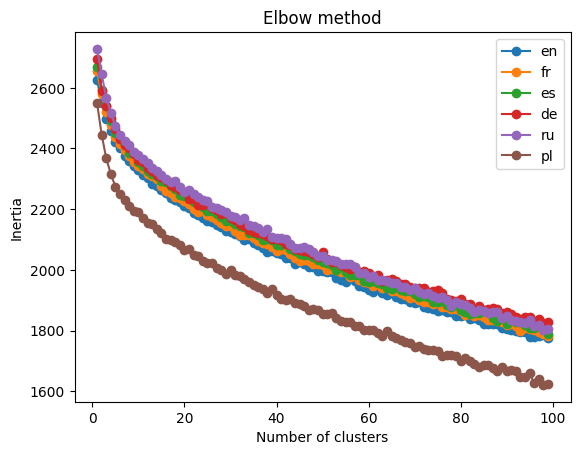

In [5]:
## plot inertia
for lang, inertia_vals in inertias.items():
    plt.plot(range(1,100), inertia_vals, marker='o', label=lang)

plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.legend()
plt.show()

In [46]:
## figure out the actual elbow point
elbow_points = {}

for lang, inertia_vals in inertias.items():
    x = range(0, len(inertia_vals))
    kn = KneeLocator(x, inertia_vals, curve='convex', direction='decreasing')
    elbow_points[lang] = kn.knee
    print(f"{lang} elbow point: {elbow_points[lang]}")

en elbow point: 28
fr elbow point: 22
es elbow point: 28
de elbow point: 22
ru elbow point: 16
pl elbow point: 15


## Actual Clustering

In [47]:
## cluster based on intertia computed
all_labels = {}
all_data_2d = {}

for lang, embeds in datas.items():
    kmeans = KMeans(n_clusters=elbow_points[lang], random_state=42)
    labels = kmeans.fit_predict(embeds)
    all_labels[lang] = labels
    
    ## show on a plane using pca
    pca = PCA(n_components=2, random_state=42)
    data_2d = pca.fit_transform(embeds)
    all_data_2d[lang] = data_2d

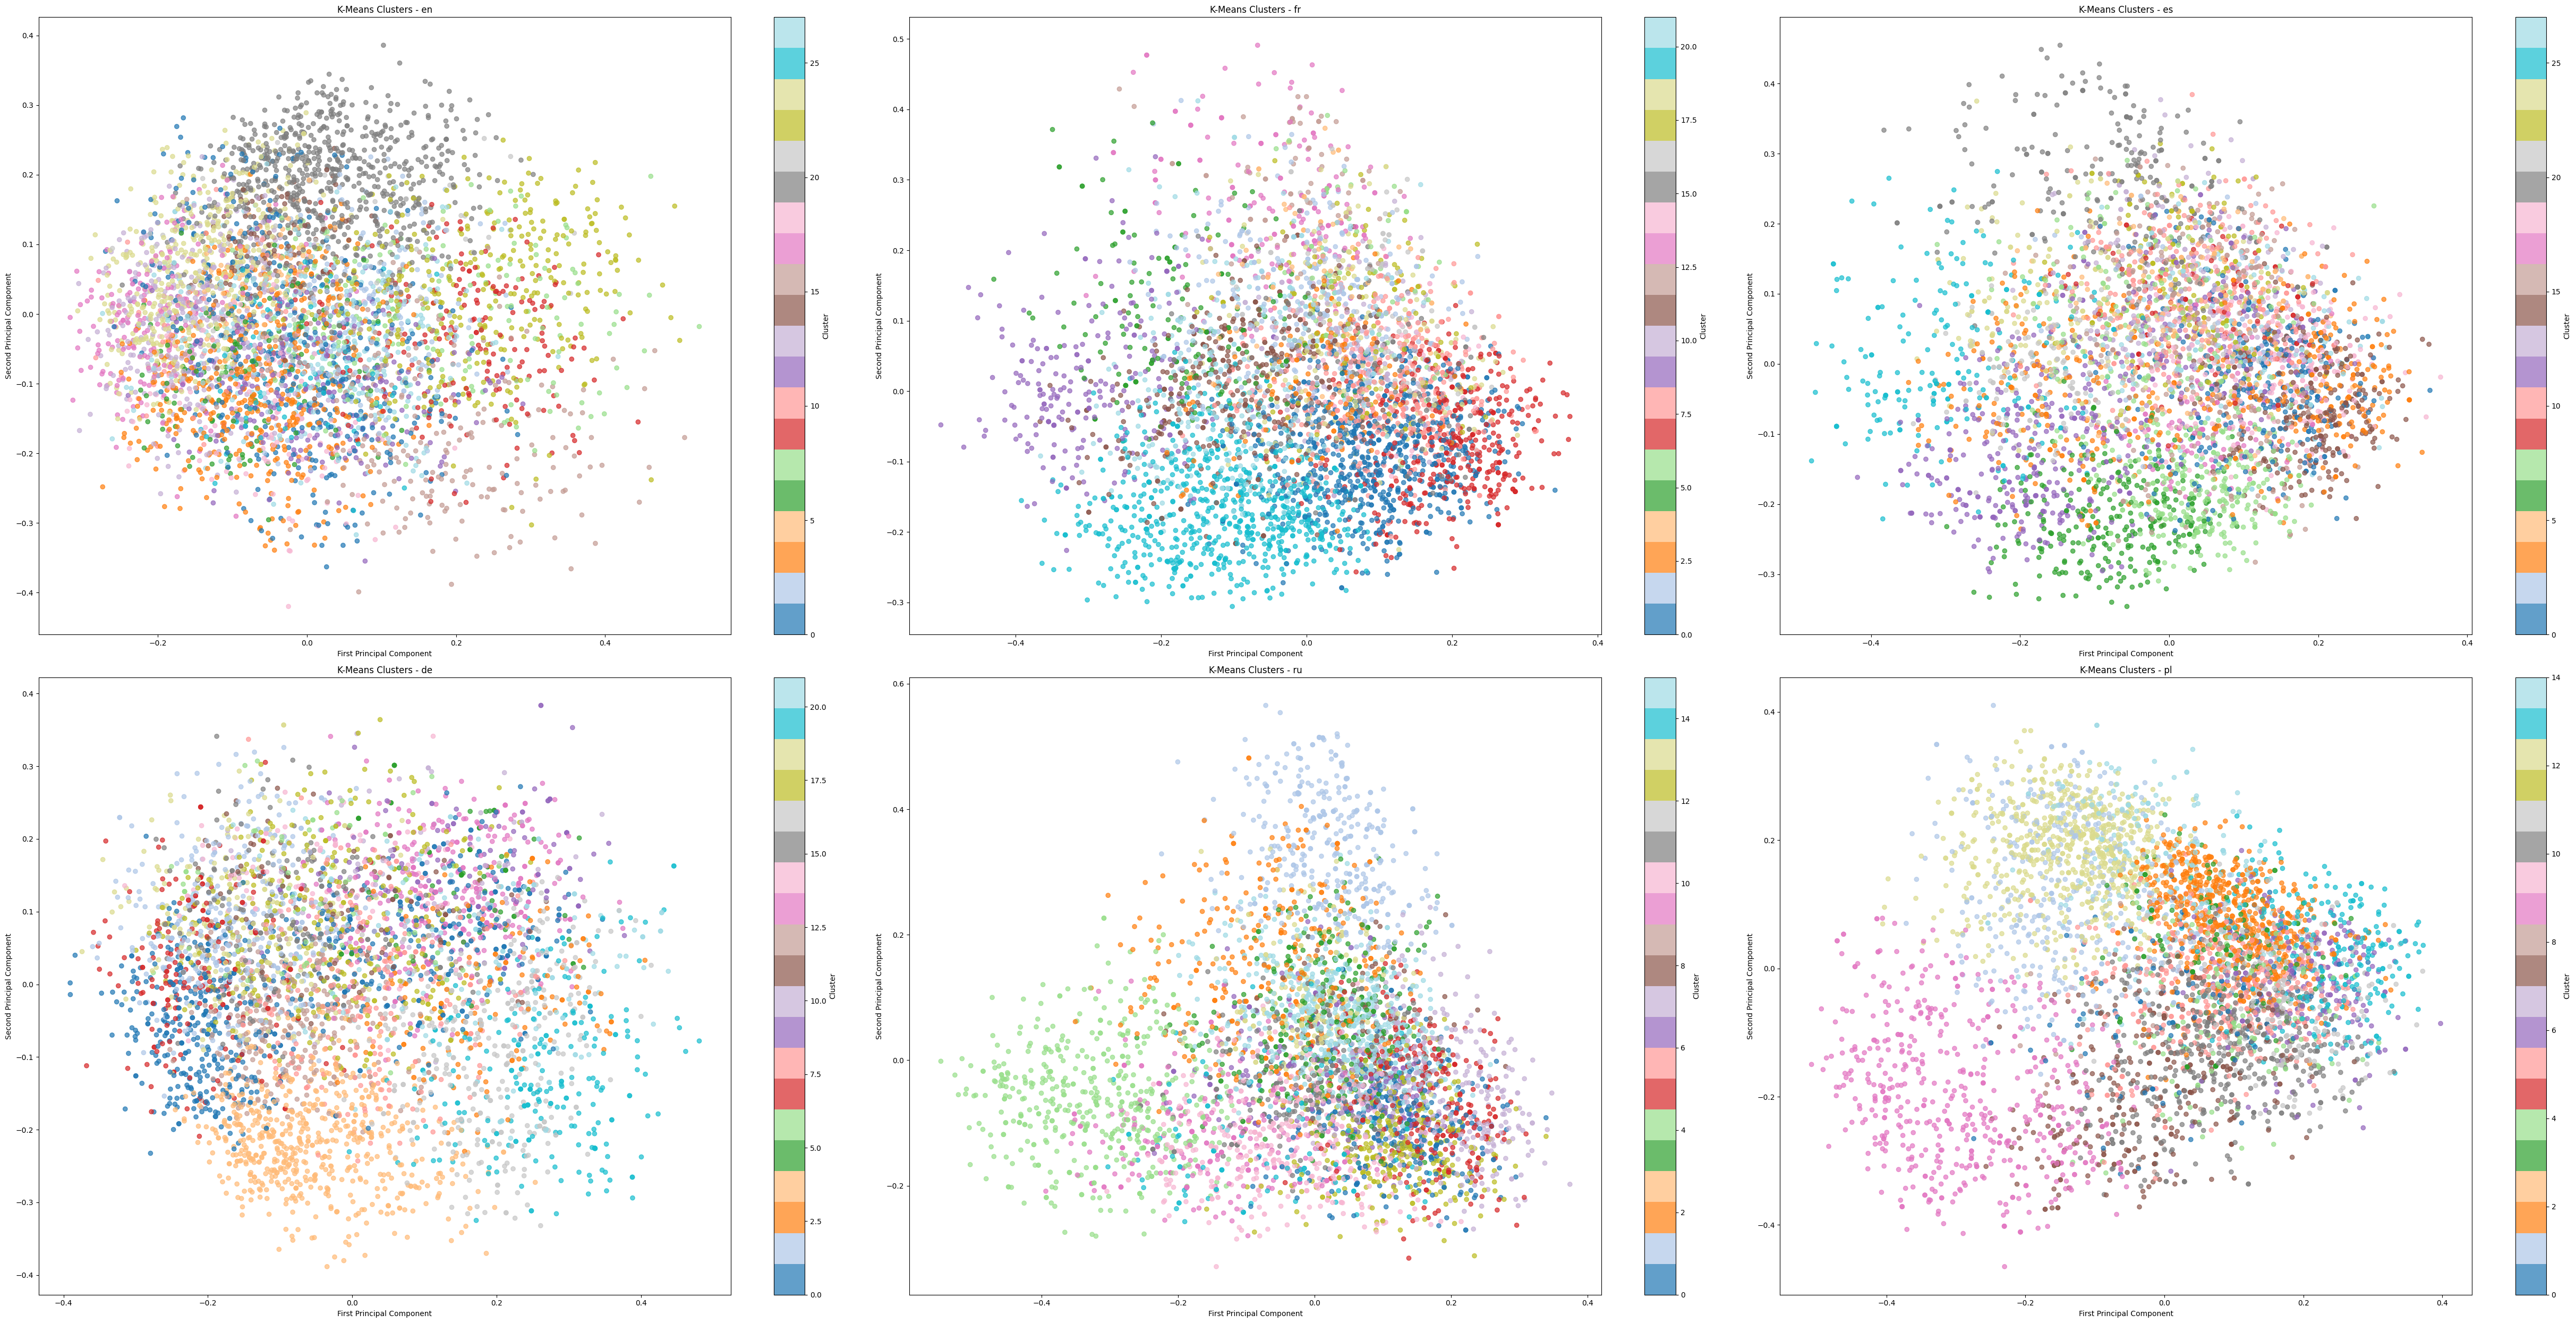

In [48]:
## show on a plane using pca
fig, axes = plt.subplots(2, 3, figsize=(50, 25))
axes = axes.flatten()

for idx, (lang, data_2d) in enumerate(all_data_2d.items()):
    labels = all_labels[lang]
    
    scatter = axes[idx].scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='tab20', alpha=0.7)
    axes[idx].set_title(f'K-Means Clusters - {lang}')
    axes[idx].set_xlabel('First Principal Component')
    axes[idx].set_ylabel('Second Principal Component')
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')

plt.tight_layout()
plt.show()

In [50]:
## print out clusters
for lang in datas.keys():
    print(f"Clusters for language: {lang}")
    labels = all_labels[lang]
    
    vocab = df[lang]
    clusters = {}

    for cluster_id in range(elbow_points[lang]):
        cluster_indices = np.where(labels == cluster_id)[0]
        clusters[cluster_id] = [vocab[i] for i in cluster_indices]

    # print all clusters
    for cluster_id, words in clusters.items():
        print(f"Cluster {cluster_id}: {words}")
    print("\n\n")

Clusters for language: en
Cluster 0: ['aircraft', 'airline', 'approach', 'arrival', 'bicycle', 'bike', 'boat', 'bus', 'car', 'carry', 'channel', 'climb', 'convert', 'course', 'cross', 'cycle', 'destination', 'direction', 'distance', 'door', 'drag', 'drive', 'driver', 'driving', 'engine', 'expedition', 'flight', 'flow', 'flying', 'follow', 'helicopter', 'journey', 'jump', 'kilometre', 'lift', 'mile', 'mobile', 'motor', 'motorcycle', 'move', 'movement', 'pass', 'passage', 'passenger', 'path', 'phase', 'plane', 'port', 'progress', 'pursue', 'race', 'race', 'racing', 'railway', 'reach', 'revolution', 'ride', 'road', 'round', 'route', 'routine', 'run', 'runner', 'running', 'sailing', 'shift', 'ship', 'skiing', 'slope', 'stage', 'step', 'stream', 'street', 'switch', 'taxi', 'through', 'tour', 'tourist', 'track', 'traffic', 'train', 'transfer', 'transform', 'transition', 'transport', 'travel', 'traveller', 'trend', 'trip', 'truck', 'tunnel', 'turn', 'vehicle', 'via', 'walk', 'way', 'wheel', '

In [51]:
## check cluster sizes
for lang in datas.keys():
    print(f"Cluster sizes for language: {lang}")
    labels = all_labels[lang]
    
    vocab = df[lang]
    clusters = {}

    for cluster_id in range(elbow_points[lang]):
        cluster_indices = np.where(labels == cluster_id)[0]
        clusters[cluster_id] = [vocab[i] for i in cluster_indices]

    # print cluster sizes
    for cluster_id, cluster in clusters.items():
        print(f"Cluster {cluster_id} length: {len(cluster)}")
        
    print("\n")

Cluster sizes for language: en
Cluster 0 length: 158
Cluster 1 length: 267
Cluster 2 length: 174
Cluster 3 length: 390
Cluster 4 length: 83
Cluster 5 length: 99
Cluster 6 length: 125
Cluster 7 length: 68
Cluster 8 length: 141
Cluster 9 length: 191
Cluster 10 length: 56
Cluster 11 length: 135
Cluster 12 length: 112
Cluster 13 length: 341
Cluster 14 length: 106
Cluster 15 length: 161
Cluster 16 length: 83
Cluster 17 length: 184
Cluster 18 length: 139
Cluster 19 length: 611
Cluster 20 length: 89
Cluster 21 length: 51
Cluster 22 length: 337
Cluster 23 length: 400
Cluster 24 length: 46
Cluster 25 length: 89
Cluster 26 length: 147
Cluster 27 length: 213


Cluster sizes for language: fr
Cluster 0 length: 144
Cluster 1 length: 591
Cluster 2 length: 314
Cluster 3 length: 121
Cluster 4 length: 66
Cluster 5 length: 178
Cluster 6 length: 72
Cluster 7 length: 385
Cluster 8 length: 455
Cluster 9 length: 241
Cluster 10 length: 131
Cluster 11 length: 416
Cluster 12 length: 64
Cluster 13 length: 179
Cl

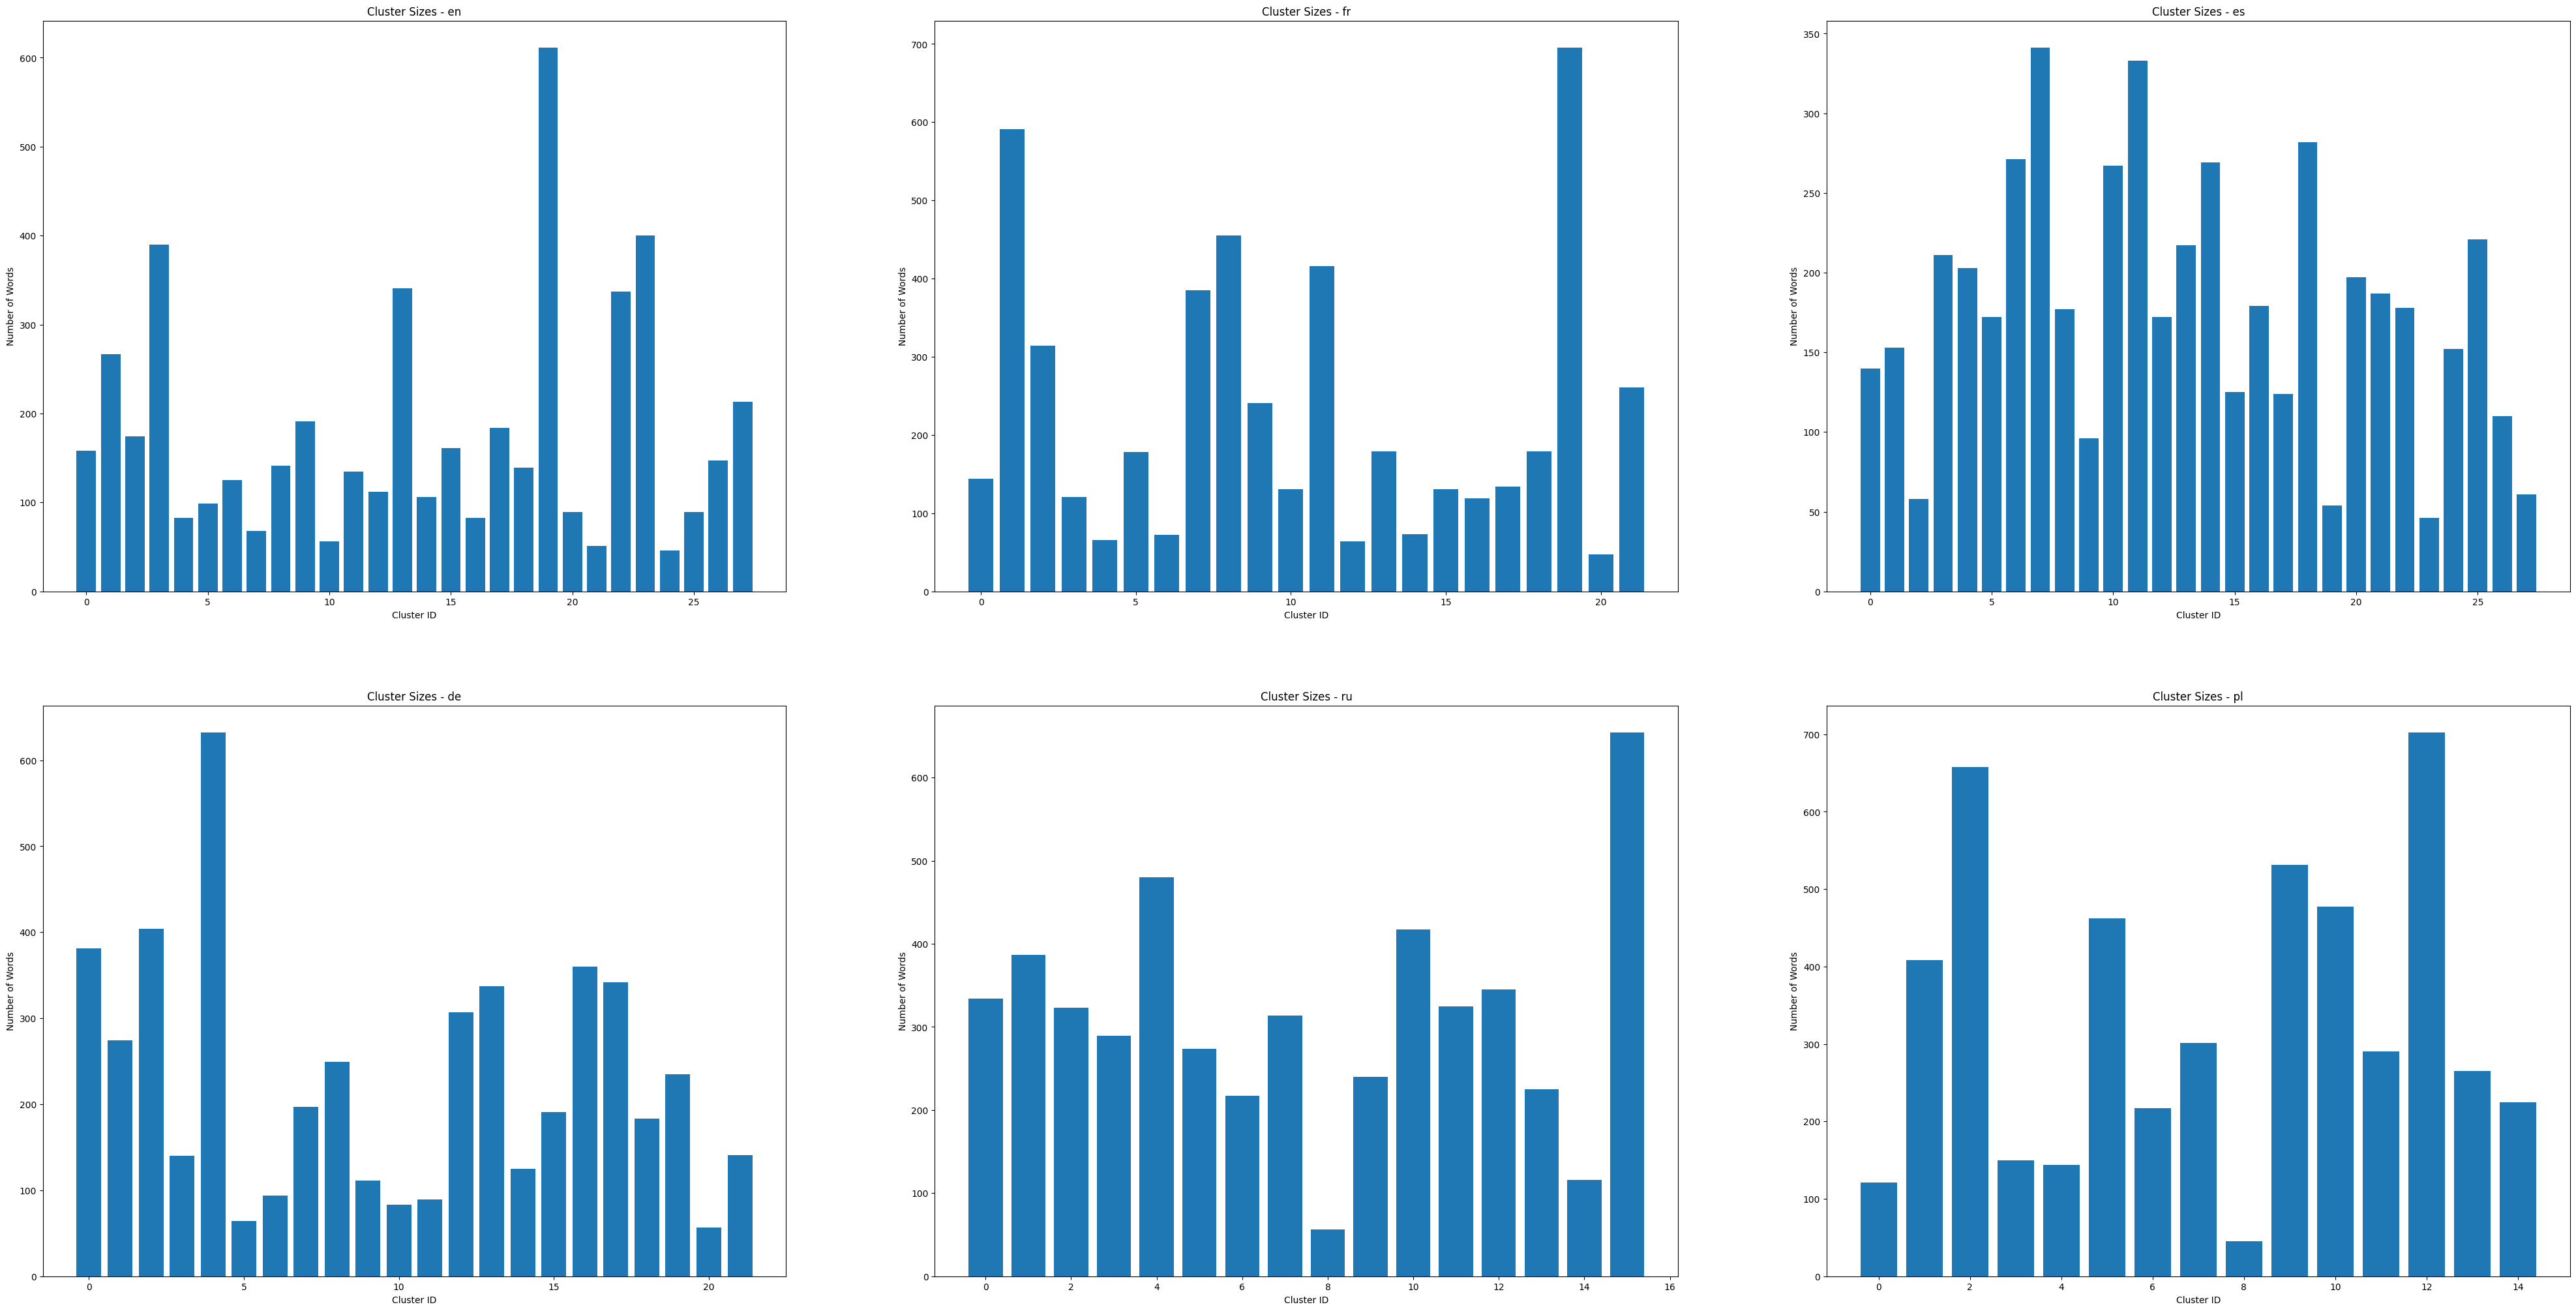

In [52]:
## plot cluster sizes for each language
fig, axes = plt.subplots(2, 3, figsize=(50, 25))
axes = axes.flatten()

for idx, lang in enumerate(datas.keys()):
    labels = all_labels[lang]
    
    vocab = df[lang]
    clusters = {}

    for cluster_id in range(elbow_points[lang]):
        cluster_indices = np.where(labels == cluster_id)[0]
        clusters[cluster_id] = [vocab[i] for i in cluster_indices]

    # get cluster sizes
    cluster_sizes = [len(cluster) for cluster in clusters.values()]
    
    axes[idx].bar(range(len(cluster_sizes)), cluster_sizes)
    axes[idx].set_title(f'Cluster Sizes - {lang}')
    axes[idx].set_xlabel('Cluster ID')
    axes[idx].set_ylabel('Number of Words')

In [54]:
## print language cluster stats
for lang in datas.keys():
    print(f"Cluster stats for language: {lang}")
    labels = all_labels[lang]
    
    vocab = df[lang]
    clusters = {}

    for cluster_id in range(elbow_points[lang]):
        cluster_indices = np.where(labels == cluster_id)[0]
        clusters[cluster_id] = [vocab[i] for i in cluster_indices]

    # print cluster sizes
    cluster_sizes = [len(cluster) for cluster in clusters.values()]
    print(f"Max cluster size: {max(cluster_sizes)}")
    print(f"Min cluster size: {min(cluster_sizes)}")
    print(f"Average cluster size: {np.mean(cluster_sizes)}")
    print(f"standard deviation of cluster sizes: {np.std(cluster_sizes)}")
    print("\n")

Cluster stats for language: en
Max cluster size: 611
Min cluster size: 46
Average cluster size: 178.42857142857142
standard deviation of cluster sizes: 128.49914634831197


Cluster stats for language: fr
Max cluster size: 695
Min cluster size: 47
Average cluster size: 227.0909090909091
standard deviation of cluster sizes: 174.4627881893727


Cluster stats for language: es
Max cluster size: 341
Min cluster size: 46
Average cluster size: 178.42857142857142
standard deviation of cluster sizes: 78.50451696350642


Cluster stats for language: de
Max cluster size: 632
Min cluster size: 57
Average cluster size: 227.0909090909091
standard deviation of cluster sizes: 139.33866822533477


Cluster stats for language: ru
Max cluster size: 654
Min cluster size: 56
Average cluster size: 312.25
standard deviation of cluster sizes: 134.9553166792624


Cluster stats for language: pl
Max cluster size: 702
Min cluster size: 45
Average cluster size: 333.06666666666666
standard deviation of cluster sizes: 

In [55]:
## save clusters as csv
for lang in datas.keys():
    print(f"Saving clusters for language: {lang}")
    labels = all_labels[lang]
    
    vocab = df[lang]
    clusters = {}

    for cluster_id in range(elbow_points[lang]):
        cluster_indices = np.where(labels == cluster_id)[0]
        clusters[cluster_id] = [vocab[i] for i in cluster_indices]

    ## convert to dataframe and save as csv
    cluster_df = pd.DataFrame()
    for cluster_id, cluster in clusters.items():
        cluster_df[cluster_id] = pd.Series(cluster)
    cluster_df.to_csv(f'clusters_{lang}.csv', index=False)  

Saving clusters for language: en
Saving clusters for language: fr
Saving clusters for language: es
Saving clusters for language: de
Saving clusters for language: ru
Saving clusters for language: pl


# Sample Items (Test)

In [57]:
## read clusers from csv
lang = "pl"
clusters = {}
cluster_df = pd.read_csv(f'clusters_{lang}.csv')
for cluster_id in cluster_df.columns:
    clusters[int(cluster_id)] = cluster_df[cluster_id].dropna().tolist()
    
## random representative from each cluster
random.seed(42) 
for cluster_id in clusters.keys():
     print(f"Representative from Cluster {cluster_id}: {random.choice(clusters[cluster_id])}")

Representative from Cluster 0: pociągający
Representative from Cluster 1: źle
Representative from Cluster 2: alarm
Representative from Cluster 3: odpowiednio
Representative from Cluster 4: prawdopodobnie
Representative from Cluster 5: Sierpień
Representative from Cluster 6: komisja
Representative from Cluster 7: oceniać
Representative from Cluster 8: wolność
Representative from Cluster 9: rysować
Representative from Cluster 10: koszt
Representative from Cluster 11: powieść
Representative from Cluster 12: mylące
Representative from Cluster 13: charakter
Representative from Cluster 14: mający szczęście
